In [4]:
import DDPG #from the article 
import torch
import gymnasium as gym
import os
import numpy as np
from utils import ReplayBuffer #from the TD3 article
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_name="HalfCheetah-v4"

In [7]:
def trainDDPG():
    if not os.path.exists("DDPGresults"):
        os.makedirs("DDPGresults")

    # Environment setup
    env_name = "HalfCheetah-v4"
    env = gym.make(env_name)
    eval_env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # Set seeds for reproducibility
    seed = 69
    env.reset(seed=seed)
    eval_env.reset(seed=seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize the agent
    policy = DDPG.DDPG(state_dim, action_dim, max_action)

    # Initialize the replay buffer
    replay_buffer = ReplayBuffer(state_dim, action_dim,max_size=int(1e6))

    # Training parameters
    max_timesteps = int(1e5)
    exploration_timesteps = 1000
    batch_size = 256
    eval_freq = 500
    eval_episodes = 10

    # Variables for tracking progress
    evaluations = []
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    eval_timesteps=[]

    # Get initial state
    state, _ = env.reset(seed=seed)
    done = False

    # Training loop
    for t in range(max_timesteps):
        episode_timesteps += 1

    # Select action
        if t < exploration_timesteps:
            # During exploration phase, use random actions
            action = env.action_space.sample()
        else:
            # Use policy to select action
            action = policy.select_action(np.array(state))
            # Add small noise for exploration
            #noise = np.random.normal(0, max_action * 0.1, size=action_dim)
            #action = (action + noise).clip(-max_action, max_action)

        # Perform action and get next state
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, float(done))

        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= exploration_timesteps:
            policy.train(replay_buffer, batch_size)

        # Reset environment if done
        if done:
            print(f"Total T: {t+1}, Episode Num: {episode_num+1}, Episode T: {episode_timesteps}, Reward: {episode_reward:.3f}")
            
            # Reset environment
            state, _ = env.reset(seed=seed)
            done = False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1

        # Evaluate agent
        if (t + 1) % eval_freq == 0:
            eval_rewards = []
            eval_timesteps.append(t+1)
            for _ in range(eval_episodes):
                eval_state, _ = eval_env.reset(seed=seed)
                eval_done = False
                eval_episode_reward = 0
                
                while not eval_done:
                    # Select action with no noise
                    eval_action = policy.select_action(np.array(eval_state))
                    eval_next_state, eval_reward, eval_terminated, eval_truncated, _ = eval_env.step(eval_action)
                    eval_done = eval_terminated or eval_truncated
                    
                    eval_episode_reward += eval_reward
                    eval_state = eval_next_state
                
                eval_rewards.append(eval_episode_reward)
            
            # Compute mean and std dev of evaluation rewards
            mean_reward = np.mean(np.array(eval_rewards))
            std_reward = np.std(np.array(eval_rewards))
            evaluations.append((mean_reward, std_reward))
        
            print(f"Evaluation at timestep {t+1}: Mean Reward = {mean_reward:.3f}, Std Dev = {std_reward:.3f}")
        
        # Save model and evaluation results

        # Save final model
    policy.save(f"DDPGresults/model_final")

        # Save evaluation results as numpy array with mean and standard deviation
    eval_data = {
        'timesteps': np.array(eval_timesteps),
        'returns_mean': np.array([x[0] for x in evaluations]),
        'returns_std': np.array([x[1] for x in evaluations])
    }
    np.save("DDPGresults/results.npy", eval_data)


In [8]:
trainDDPG()

Evaluation at timestep 500: Mean Reward = -2.270, Std Dev = 0.000
Total T: 1000, Episode Num: 1, Episode T: 1000, Reward: -259.997
Evaluation at timestep 1000: Mean Reward = -2.270, Std Dev = 0.000
Evaluation at timestep 1500: Mean Reward = -114.160, Std Dev = 0.000
Total T: 2000, Episode Num: 2, Episode T: 1000, Reward: -405.561
Evaluation at timestep 2000: Mean Reward = -387.295, Std Dev = 0.000
Evaluation at timestep 2500: Mean Reward = -434.963, Std Dev = 0.000
Total T: 3000, Episode Num: 3, Episode T: 1000, Reward: -459.949
Evaluation at timestep 3000: Mean Reward = -540.613, Std Dev = 0.000
Evaluation at timestep 3500: Mean Reward = -570.094, Std Dev = 0.000
Total T: 4000, Episode Num: 4, Episode T: 1000, Reward: -541.669
Evaluation at timestep 4000: Mean Reward = -589.833, Std Dev = 0.000
Evaluation at timestep 4500: Mean Reward = -456.057, Std Dev = 0.000
Total T: 5000, Episode Num: 5, Episode T: 1000, Reward: -479.795
Evaluation at timestep 5000: Mean Reward = -420.444, Std De

In [6]:
from scipy.ndimage import uniform_filter1d
def plot_results(results_file, window_size=5, save_path=None):
    """
    Plot TD3 training results with smoothing and standard deviation visualization.
    
    Args:
        results_file (str): Path to the .npy file containing results
        window_size (int): Size of the smoothing window
        save_path (str, optional): If provided, save the figure to this path
    """
    # Load results
    data = np.load(results_file, allow_pickle=True).item()
    
    timesteps = data['timesteps']
    returns_mean = data['returns_mean']
    returns_std = data['returns_std']
    
    # Apply uniform smoothing
    smoothed_mean = uniform_filter1d(returns_mean, size=window_size)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot mean with fill between for std
    plt.plot(timesteps, smoothed_mean, color='blue', linewidth=2, label='Mean Return (Smoothed)')
    plt.fill_between(
        timesteps, 
        smoothed_mean - returns_std, 
        smoothed_mean + returns_std, 
        alpha=0.2, 
        color='blue',
        label='Standard Deviation'
    )
    
    # Additional plot styling
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('Return', fontsize=12)
    plt.title('DDPG Training Performance on HalfCheetah-v4', fontsize=14)
    plt.legend(loc='best')
    
    # Add training details text box
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = '\n'.join((
        'Training Details:',
        f'Total Timesteps: {int(timesteps[-1])}',
        f'Final Return: {returns_mean[-1]:.2f} ± {returns_std[-1]:.2f}',
        f'Max Return: {np.max(returns_mean):.2f}'
    ))
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()

Figure saved to DDPGresults/DDPGfig.png


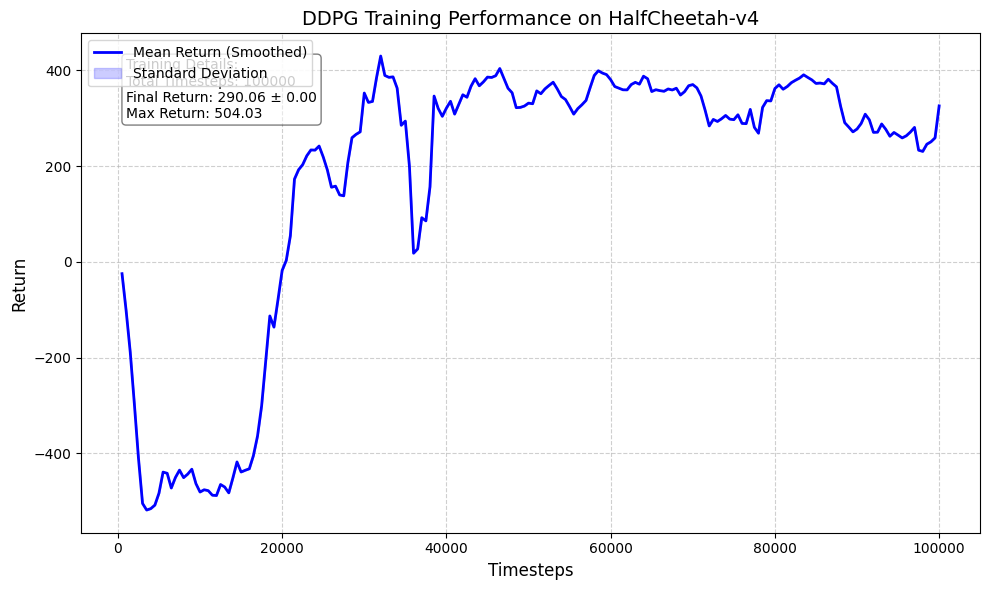

In [7]:
results_files='DDPGresults/results.npy'
save_path='DDPGresults/DDPGfig.png'
plot_results(results_file=results_files,save_path=save_path)